# Testing parameter retrieval using finite time window InSAR acquisition for a future Enceladus mission
___
Rishav Mallick & Mark Simons
___

The general displacement observation of an unwrapped InSAR measurement is given by   
$$\Delta u_{los}^{a-b} = (\mathbf{u}_a - \mathbf{u}_b).\hat{\mathbf{l}} + b^{a-b} + \epsilon^{a-b}$$

where $b^{a-b}$ is the error associated with errors in perpendicular baseline while $\epsilon^{a-b}$ refers to other errors. The displacements can arise from a number of different processes, but in this case we are interested in a time series of the form:

$$ \mathbf{u}(\mathbf{r},t) = \mathbf{u}_0(\mathbf{r}) + \mathbf{v}(\mathbf{r})t + \mathbf{A}(\mathbf{r})\sin\left(\omega t + \pmb{\phi}\right)$$

where $\mathbf{v},\omega,\pmb{\phi}$ are the secular velocity, oscillatory frequency and phase shift of the dominant sinusoid at the observation point $\mathbf{r}$.

The line-of-sight (LOS) vector can be calculated using the flight azimuth and look angle as follows: 

In [37]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors

look_angle    = 30 # look angle in degrees
azimuth_angle = 20 # satellite heading in degrees
la            = np.deg2rad(look_angle)    # convert to radians
az            = np.deg2rad(azimuth_angle) # convert to radians

#los_vec       = np.array([np.cos(la) * np.cos(az), np.cos(la) * np.sin(az), -np.sin(la)]), error?
los_vec       = np.array([np.sin(la) * np.cos(az), np.sin(la) * np.sin(az), -np.cos(la)])


### Error model for imperfect DEM and perpendicular baselines

The phase induced by an error in the DEM of $\delta h$ can be estimated using the following relationship:
$$ \rho_{\delta h} = \frac{B_{\perp}}{r_0\sin\theta_0}\delta h $$
where $B_{\perp}$ is the perpendicular baseline for the 2 acquisitions, $r_0,\sin\theta_0$ are the range and incidence angle. 

### Enceladus application
For Enceladus, the orbital period around Saturn is the same as the tidal period (32.88 hrs). The mission  plans to revisit the same imaging track every 29.5 hrs during the InSAR campaign. This means that it will be possible to estimate the amplitude and phase of the sinusoidal forcing term from the SAR time series. However, we would like to know how much acquisition will it require for us to do this robustly, given  typical noise in the data?

### Define Parameters 

In [38]:
# Define all parameters used in this notebook

year2hours   = 365*24

# Enceladus parameters
tidal_period = 32.88 # hours
A            = np.array([1,0.2,3]) # amplitude of periodic displacements componentsin (m)
omega        = 2*np.pi/tidal_period # 2pi/hours #frequency
phi          = np.deg2rad(1)

u_0          = np.array([0,0,0]) # arbitrary initial position in (m)
v            = np.array([0.1,0.3,0])/year2hours# convert from m/yr to m/hour

# SAR mission acquisition period
one_cycle    = 30.5 # time for satellite to return to the same spot in hours (assumes the 5:1 orbit)
stride       = 2    # number of cycles spanned by a given interferogram - 1 implies consecutive acquistions
t_cycle      = one_cycle*stride # time spanned by each consecutive igram in hours

# perpendicular baseline parameters
r_0          = 200e3 # slant range in m (should be updated for real geometry)
theta_0      = la    # look angle in radians (should be updated to reflect incidence angle)
dh           = 100   # assumed error in topography in (m)
B_perp_max   = 133   # maximum B_perp (1-sigma of the tube radius) in (m)
B_perp_error =  2    # error in measuring B_perp in (m)

# ***phase error due to volumetric decorrelation in ice
# ***NOTE*** this term should eventually be replaced by something dependent on each realization of the baseline
sigma_hat_2  = 0.01**2 # fixed value in m^2 

# for the looping section (when observation window is varied)
duration_min   = year2hours/4  #hrs (since errors drop quickly, it can be useful to only look beyond the initial stage)
duration_max   = year2hours*1  #hrs
duration_steps = year2hours/52 #hrs

### A single fixed duration InSAR campaign example
We first consider a fixed InSAR campaign duration, and predict the deformation time series.

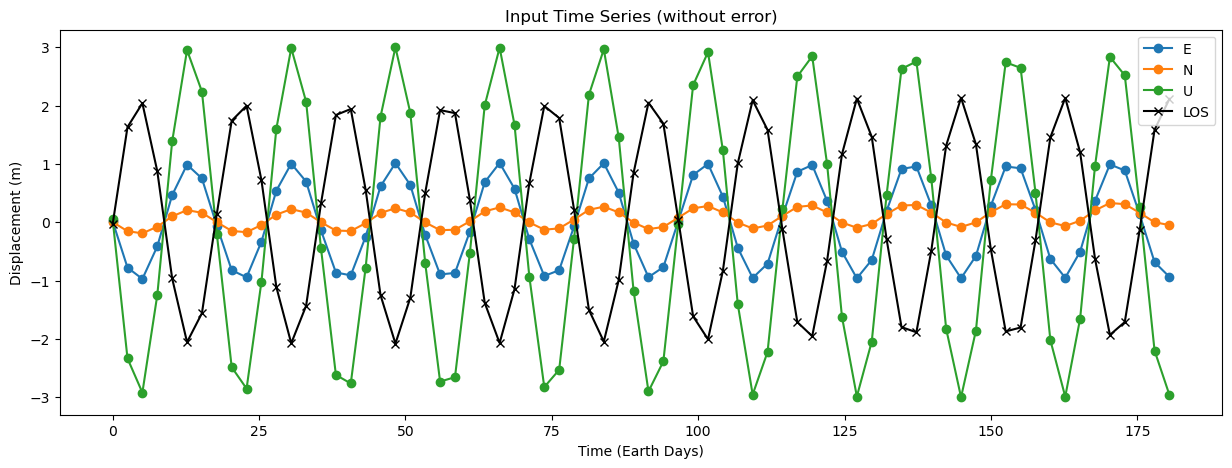

In [39]:
# specify time of acquisitions as a vector for a fixed total duration
t_duration = 24*365/2 # hours,  
t_obs      = np.arange(0,t_duration,t_cycle) # in hours

# predict observations at a given site without any noise and convert to LOS
u_obs = u_0.reshape(-1,1) + v.reshape(-1,1)*t_obs.reshape(1,-1) + A.reshape(-1,1)*np.sin(omega*t_obs+phi).reshape(1,-1)
u_los = los_vec.reshape(1,-1) @ u_obs

# plot time series
plt.figure(figsize=(15, 5))
plt.plot(t_obs/24,(u_obs.T),'o-',label=['E','N','U'])
plt.plot(t_obs/24,(u_los.T),'kx-',label='LOS')
plt.legend()
plt.xlabel('Time (Earth Days)')
plt.ylabel('Displacement (m)')
plt.title('Input Time Series (without error)')
plt.show()

We assume a Gaussian distribution of $B_{\perp}$. We also assume an error on the knowledge of $B_{\perp}$.  Both are predictions from the navigation team.

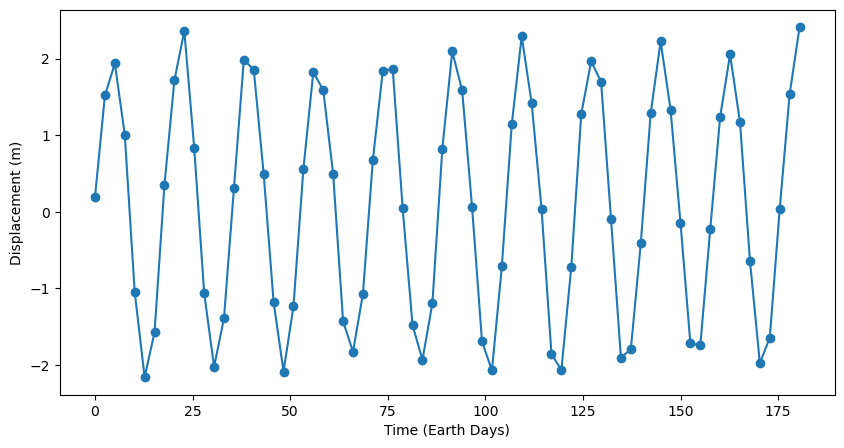

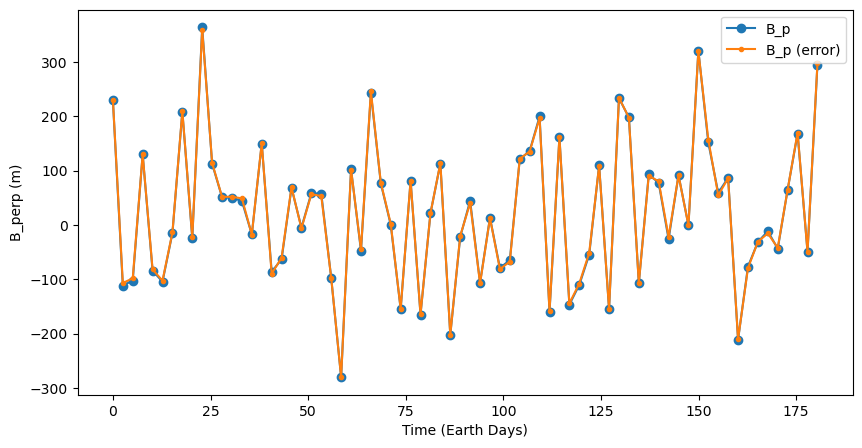

In [40]:
B_perp = np.random.normal(0,B_perp_max,[1,len(t_obs)])

# real observation
u_los_o = u_los + dh*B_perp/r_0/np.sin(theta_0)

# plot the observed los displacement time series
plt.figure(figsize=(10,5))
plt.plot(t_obs/24,(u_los_o.T),'o-')
plt.xlabel('Time (Earth Days)')
plt.ylabel('Displacement (m)')
plt.show()

B_perp_model = B_perp + B_perp_error*np.random.normal(size=(1,len(t_obs)))

plt.figure(figsize=(10,5))
plt.plot(t_obs/24,np.transpose(B_perp),'o-',label='B_p')
plt.plot(t_obs/24,np.transpose(B_perp_model),'.-',label='B_p (error)')
plt.xlabel('Time (Earth Days)')
plt.ylabel('B_perp (m)')
plt.legend()
plt.show()

### Inverse problem
To estimate the model parameters in a given LOS direction i.e., $\mathbf{\hat{m}} = [v,A_1,A_2,\delta h,u_0]$ we need to first develop a model for the perpendicular baselines based on the errors that arise from the imperfect knowledge of the baseline itself. Here, we assume that the error is fixed at $\epsilon_{B_p} = 2$ m.

$A_1,A_2$ comes from the decomposition of $A\sin(\omega t + \phi) = A_1\sin(\omega t) + A_2\cos(\omega t)$


The model parameters can be estimated by linear matrix inverse methods by constructing a design matrix $G$,

$$ \hat{m} = \left(G^TG\right)^{-1}u$$
the uncertainties in the model parameters are then
$$C_m = \hat{\sigma}^2\left(G^TG\right)^{-1}$$

There are two ways to estimate $\hat{\sigma}^2$, one way is to use the residuals from the best-fit predictions $\hat{\sigma}^2 = \frac{(u-G\hat{m})^T(u-G\hat{m})}{N_{dof}}$ where $N_{dof}$ is the total degrees of freedom. This term is an ad-hoc scalar estimate of the uncertainty on the data (given an associated model). Alternatively, we can propagate the phase error due to volumetric decorrelation $\hat{\sigma}$, as a measure of the phase uncertainty.  Ideally, this would scale with $B_{\perp}$ (future work).

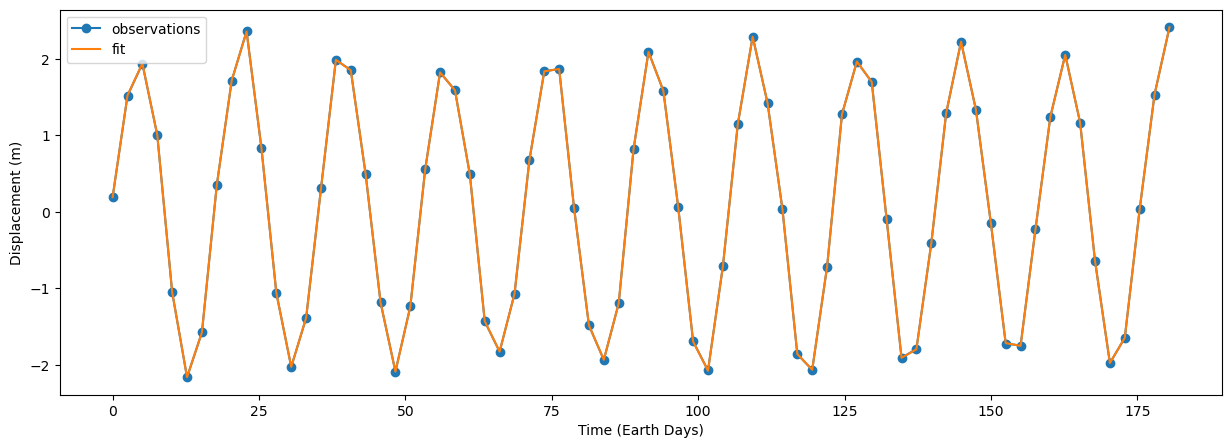

In [41]:
# inverse problem

Gmat = np.concatenate([t_obs.reshape(-1,1),
                       np.sin(omega*t_obs).reshape(-1,1),
                       np.cos(omega*t_obs).reshape(-1,1),
                       np.transpose(B_perp_model)/r_0/np.sin(theta_0),
                       np.ones_like(t_obs.reshape(-1,1))],axis=1)
m_hat,*_ = np.linalg.lstsq(Gmat, u_los_o.T,rcond=None)

# uncertainties
C_m         = np.linalg.inv(Gmat.T@Gmat)

# extract mean, covariance matrix associated with sinusoidal amplitudes
A_cov       = sigma_hat_2*C_m[1:3,1:3]
A_mu        = m_hat[1:3].flatten()
vals1,vals2 = np.random.multivariate_normal(A_mu,A_cov,1000).T
A_mag       = np.sqrt(vals1**2 + vals2**2)
A_phase     = np.arctan(vals2/vals1)

# plt.polar(A_phase,A_mag,'.')
# plt.show()
# print(scipy.stats.circmean(A_phase),scipy.stats.circstd(A_phase))

# plot fit to observations
plt.figure(figsize=(15, 5))
plt.plot(t_obs/24,u_los_o.T,'o-',label='observations')
plt.plot(t_obs/24,Gmat@m_hat,'-',label='fit')
plt.xlabel('Time (Earth Days)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.show()

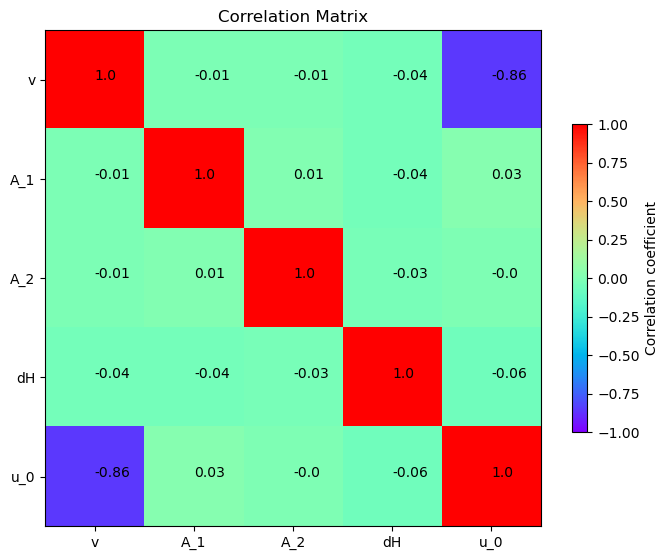

In [42]:
# compute uncertainties in model parameter estimates
res = u_los_o.T - Gmat@m_hat
# sigma_hat_2 = (res.T@res/(len(t_vec)-len(m_hat))).item()

sigma_m = np.sqrt(sigma_hat_2*np.diag(C_m))
# print(sigma_hat_2)
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation
Corr_m = correlation_from_covariance(C_m)

# plot model covariance matrix
plt.figure(figsize=(8,8))
# plt.imshow(sigma_hat_2*C_m, cmap='rainbow', norm=colors.SymLogNorm(linthresh=1e-10,
                                            #   vmin=-.1, vmax=.1))
plt.imshow(Corr_m, cmap='rainbow',vmin=-1,vmax = 1)
for i in range(0,len(m_hat)):
    for j in range(0,len(m_hat)):
        plt.text(i,j,Corr_m[i,j].round(2))

plt.colorbar(shrink=0.5,label='Correlation coefficient')
ax=plt.gca()
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
ax.set_xticklabels(["v","A_1","A_2","dH","u_0"])
ax.set_yticklabels(["v","A_1","A_2","dH","u_0"])
plt.title('Correlation Matrix')
plt.show()


## Estimated uncertainty in recovered parameters as a function of the duration of the InSAR campaign duration

How much data is needed to know the model parameters to a specified precision level, given the proposed sampling interval (stride) and the knowledge we have about the sources of noise/error? Here, we define the observation time window as a systematically varied parameter, and then estimate the model parameters as before.


In [43]:
t_obs        =  np.arange(0,duration_max,t_cycle) # in hours
B_perp       = np.random.normal(0,B_perp_max,[1,len(t_obs)])
B_perp_model = B_perp + B_perp_error*np.random.normal(size=(1,len(t_obs)))

# predict observations at a given site and convert to los
u_obs   = u_0.reshape(-1,1) \
        + v.reshape(-1,1)*t_obs.reshape(1,-1) \
        + A.reshape(-1,1)*np.sin(omega*t_obs+phi).reshape(1,-1)
u_los   = los_vec.reshape(1,-1) @ u_obs               
u_los_o = u_los + dh*B_perp/r_0/np.sin(theta_0)
            
t_duration_vec = np.arange(duration_min,duration_max,duration_steps) # in hours 

param_mu       = np.zeros((len(m_hat),len(t_duration_vec)))
param_sigma    = np.zeros((len(m_hat),len(t_duration_vec)))

A_mean         = np.zeros((2,len(t_duration_vec)))
A_sigma        = np.zeros((2,len(t_duration_vec)))

for i in range(0,len(t_duration_vec)):
    tindex = t_obs<t_duration_vec[i]
    t_vec  = t_obs[tindex]
    u_vec  = u_los_o[0,tindex]
    
    B_perp_model_vec = B_perp_model[0,tindex]
    
    Gmat   = np.concatenate([t_vec.reshape(-1,1),
                           np.sin(omega*t_vec).reshape(-1,1),
                           np.cos(omega*t_vec).reshape(-1,1),
                           B_perp_model_vec.reshape(-1,1)/r_0/np.sin(theta_0),
                           np.ones_like(t_vec.reshape(-1,1))],axis=1)
    
    m_hat,*_ = np.linalg.lstsq(Gmat, u_vec.reshape(-1,1),rcond=None)
    # uncertainties
    C_m      = np.linalg.inv(Gmat.T@Gmat)
    
    # res = u_vec.reshape(-1,1) - Gmat@m_hat
    A_cov        = sigma_hat_2*C_m[1:3,1:3]
    A_mu         = m_hat[1:3].flatten()
    vals1,vals2  = np.random.multivariate_normal(A_mu,A_cov,1000).T
    A_mag        = np.sqrt(vals1**2 + vals2**2)
    A_phase      = np.arctan(vals2/vals1)

    A_mean[0,i]  = A_mag.mean()
    A_mean[1,i]  = scipy.stats.circmean(A_phase)
    A_sigma[0,i] = A_mag.std()
    A_sigma[1,i] = scipy.stats.circstd(A_phase)

    sigma_m      = np.sqrt(sigma_hat_2*np.diag(C_m))
    
    param_mu[:,i]    = m_hat.T
    param_sigma[:,i] = sigma_m

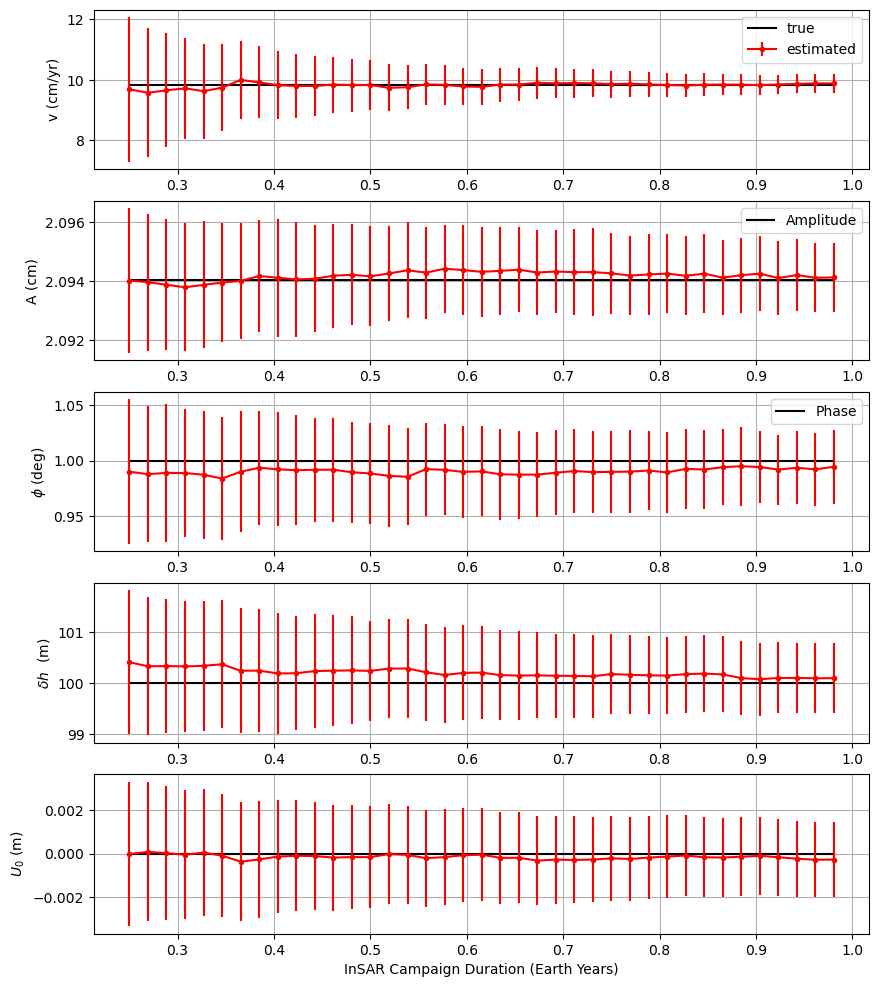

In [44]:

fig, axs = plt.subplots(5, 1, figsize=(10, 12))

axs = axs.ravel()

toplot = los_vec.reshape(1,-1)@v*365*24*100
axs[0].plot(t_duration_vec/year2hours, toplot*np.ones_like(t_duration_vec), 'k-',label='true')
axs[0].errorbar(t_duration_vec/year2hours, param_mu[0,:]*365*24*100,yerr = 100*365*24*param_sigma[0,:],fmt='r.-',label='estimated')
axs[0].legend()
axs[0].set_ylabel('v (cm/yr)')

toplot = los_vec.reshape(1,-1)@A
axs[1].plot(t_duration_vec/year2hours, abs(toplot)*np.ones_like(t_duration_vec), 'k-',label='Amplitude')
# axs[1].errorbar(t_duration_vec/year2hours, param_mu[1,:],yerr = param_sigma[1,:],fmt='r.-')
axs[1].errorbar(t_duration_vec/year2hours, A_mean[0,:],yerr = A_sigma[0,:],fmt='r.-')
axs[1].set_ylabel('A (cm)')
axs[1].legend()

toplot = np.rad2deg(phi)
axs[2].plot(t_duration_vec/year2hours, toplot*np.ones_like(t_duration_vec), 'k-',label='Phase')
# axs[2].errorbar(t_duration_vec/24, param_mu[2,:],yerr = param_sigma[2,:],fmt='r.-')
axs[2].errorbar(t_duration_vec/year2hours, np.rad2deg(A_mean[1,:]),yerr = np.rad2deg(A_sigma[1,:]),fmt='r.-')
axs[2].set_ylabel('$\phi$ (deg)')
axs[2].legend()

axs[3].plot(t_duration_vec/year2hours, dh*np.ones_like(t_duration_vec), 'k-')
axs[3].errorbar(t_duration_vec/year2hours, param_mu[3,:],yerr = param_sigma[3,:],fmt='r.-')
axs[3].set_ylabel('$\delta h$  (m)')

toplot = los_vec.reshape(1,-1)@u_0
axs[4].plot(t_duration_vec/year2hours, toplot*np.ones_like(t_duration_vec), 'k-')
axs[4].errorbar(t_duration_vec/year2hours, param_mu[4,:],yerr = param_sigma[4,:],fmt='r.-')
axs[4].set_ylabel('$U_0$ (m)')
axs[4].set_xlabel('InSAR Campaign Duration (Earth Years)')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()

plt.show()

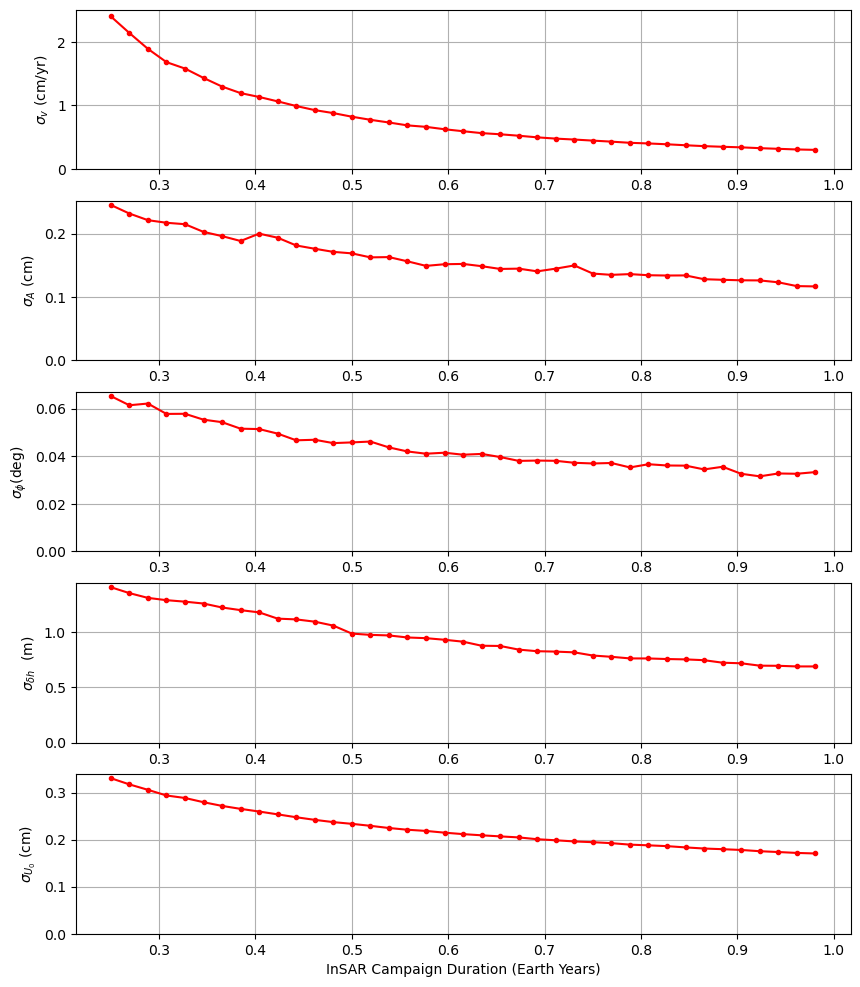

In [45]:
fig, axs = plt.subplots(5, 1, figsize=(10, 12))

axs = axs.ravel()

axs[0].plot(t_duration_vec/year2hours, 100*365*24*param_sigma[0,:],'r.-')
axs[0].set_ylabel('$\sigma_v$ (cm/yr)')
plt.grid()

toplot = los_vec.reshape(1,-1)@A
axs[1].plot(t_duration_vec/year2hours, 100*A_sigma[0,:],'r.-')
axs[1].set_ylabel('$\sigma_A$ (cm)')
plt.grid()

axs[2].plot(t_duration_vec/year2hours, np.rad2deg(A_sigma[1,:]), 'r.-')
axs[2].set_ylabel('$\sigma_\phi$(deg)')
plt.grid()

axs[3].plot(t_duration_vec/year2hours, param_sigma[3,:], 'r.-')
axs[3].set_ylabel('$\sigma_{\delta h}$  (m)')
plt.grid()

axs[4].plot(t_duration_vec/year2hours, 100*param_sigma[4,:], 'r.-')
axs[4].set_ylabel('$\sigma_{U_0}$ (cm)')
axs[4].set_xlabel('InSAR Campaign Duration (Earth Years)')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()
axs[0].axes.set_ylim([0,None]) 
axs[1].axes.set_ylim([0,None]) 
axs[2].axes.set_ylim([0,None]) 
axs[3].axes.set_ylim([0,None]) 
axs[4].axes.set_ylim([0,None]) 
plt.show()

### Takeaways

Currently, we assume a 1 cm phase variance for each interferogram.  This number is taken from a simple single scatterer model model with 40 m penetration of the S-Band SAR energy, a nominal incidence angle, and a 40 m pixel size.  In the future, this estimate can be refined and should be made baseline and incidence angle dependent. 

We propagate this phase variance through a simple model with periodic (tidal) and secular motion, as well as an uncertainty in the DEM.  We find that we can recover (i.e., correct) the DEM to 3 m accuracy within a month and to better than 1 m accuracy within 6 months. 

The secular velocity is the most demanding observable.  We find that we can recover it to within 1 cm/yr within 5.4 months. After a year, our error on the secular velocity is 0.25 cm/yr.  The spatial resolution for the secular velocity can be coarser than the default 40 m.  If we are content with a 400 m pixel, then our sensitivity improves by a factor of 10 (e.g., 1 mm/yr in less than 6 months).

Tidal phase is recovered absurdly well (much less than a degree).

Caveats - Our assumed error for a given interferogram is a best guess at the moment.  Our temporal model for surface deformation is very simple and does not include steps due to discrete events (e.g., sudden fault slip) or other superimposed processes (e.g., dyking or other cryovolcanic processes).